# Ejercicio 3 - Kernel bidimensional para procesar una imagen

---

In [10]:
# Ejecutar en Google Colab
!pip install numpy matplotlib scikit-image numba cython setuptools

In [11]:
### EVITAR ERRORES

!uv pip install -q --system numba-cuda==0.4.0

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

Image size:  (512, 512)


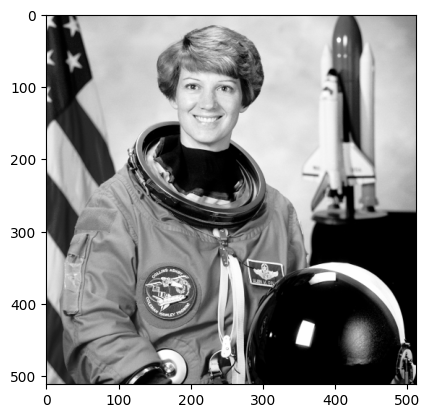

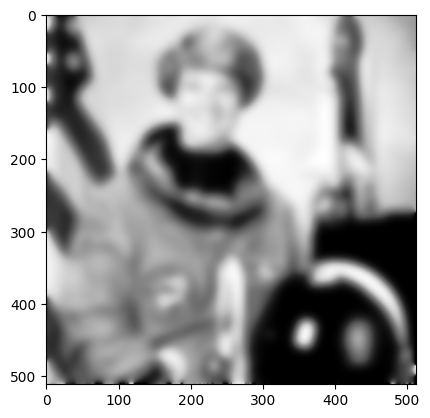

In [12]:
# Necesitamos skimage
# Instalar con
#       conda install scikit-image
from numba import cuda
import matplotlib.pyplot as plt
from skimage import data, color
import numpy as np

# Función blur
@cuda.jit
def blur(input, output):
    x, y = cuda.grid(2)  # coordenadas (fila, columna) del hilo

    # asegurar que el hilo no está en el borde (evita desbordamiento de índices)
    if x > 0 and y > 0 and x < (input.shape[0] - 1) and y < (input.shape[1] - 1):

        # promedio de los 4 vecinos (arriba, abajo, izquierda, derecha)
        output[x][y] = 0.25*(input[x-1][y]+input[x+1][y]+input[x][y-1]+input[x][y+1])

    # si está en le borde --> MISMO valor (sin desenfoque)
    else:
        output[x][y] = input [x][y]

# Parámetros
num_cycles = 100 # 100 ciclos --> desenfocado gradual

# Hilos y bloques
threads_per_block = (32, 32)
blocks = (16, 16)

# Imagen
astronaut = (255.-color.rgb2gray(data.astronaut()))/255.0
print("Image size: ",astronaut.shape) # tamaño
fig, ax = plt.subplots()
im = ax.imshow(astronaut,  cmap='Greys')

# Datos a GPU (duplicar imagen)
d_astronaut = cuda.to_device(astronaut) # input
d_astronaut_blurred =  cuda.device_array_like(d_astronaut) # out

# Ejecutar num_cycles veces un el kernel blur
for _ in range(num_cycles):
    blur[blocks, threads_per_block](d_astronaut, d_astronaut_blurred) # ejecutar kernel
    cuda.synchronize() # esperar a que termine: RECOMENDADO para PROTECCIÓN EXTRA
    d_astronaut = d_astronaut_blurred # reescribir para seguir iterando

# Copiar imagen desenfocada al host
astronaut_blurred = d_astronaut_blurred.copy_to_host() # copiar a CPU

# Mostrar imagen
fig, ax = plt.subplots()
im = ax.imshow(astronaut_blurred, cmap='Greys')